In [27]:
stock_symbol = '#PLTR'  # Beispiel: PLTR, kann angepasst werden
#import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
n_pred_days = 100 # Anzahl der Tage für die Vorhersage
# Dow Theorie: Trendanalyse
def dow_theory(data):
    # Identifikation von Aufwärtstrends und Abwärtstrends (basiert auf Schlusskursen)
    data['Trend'] = np.where(data['close'] > data['close'].shift(1), '1', '0')
    return data



# Elliott Wellen Theorie: Eine einfache Methode zur Identifikation von Wellen
def elliott_wave(data):
    # Berechnung der Rückgänge und Anstiege (ein rudimentäres Beispiel)
    data['Wave_Up'] = np.where(data['close'] > data['close'].shift(1), 1, 0)
    data['Wave_Down'] = np.where(data['close'] < data['close'].shift(1), 1, 0)
    
    # Identifikation von Wellen (dies ist ein vereinfachtes Beispiel)
    data['Wave_Count'] = data['Wave_Up'].cumsum() - data['Wave_Down'].cumsum()
    return data

# Daten laden
#df = yf.download('TSLA', start='2020-01-01')


folderPath_His = "/Users/Shared/ai_work/Trainingdata/ml_data/yh_his/D1/"


lastBars = 0
n_time_steps = 60 # Anzahl der Zeitstufen
n_pred_days3 = 60 # Anzahl der Vorhersagetage
n_tail= 200
df = pd.read_csv (folderPath_His + stock_symbol + ".csv")
print (df.head())
df_his = df.tail(lastBars+1)
df_his["date"] = pd.to_datetime(df["date"])
#dt.strftime('%Y-%m-%d')


#df["date"] = df["date"].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))
df["date"] = pd.to_datetime(df["date"], format='%Y-%m-%d')

df = df.set_index('date')
df = dow_theory(df)

df = elliott_wave(df)
df = df[:len(df) - lastBars]

print (df)
#df['AUDUSD_close'] = df['AUDUSD_close'].shift(1)
"""
df = df[['open', 'high', 'low', 'close','volume','AUDUSD_close','F_TNote_10Y_close','F_TNote_10Y_volume','cot_noncom_long','cot_com_short',
         'cot_noncom_short','cot_openinterest','F_TYield_13W_close','F_US_TBond_close','F_US_TBond_volume','F_VIX_close',
         'F_USDX_close','Trend','Wave_Down','Wave_Up','Wave_Count']]
"""
df1 = df[['open', 'high', 'low', 'close', 'volume']]
df['MA_14'] = df['close'].rolling(window=14).mean()
df['MA_50'] = df['close'].rolling(window=50).mean()
df['MA_200'] = df['close'].rolling(window=200).mean()
df['RSI_14'] = 100 - (100 / (1 + df['close'].pct_change().add(1).rolling(14).apply(lambda x: (x[x > 0].mean() / abs(x[x < 0].mean())) if abs(x[x < 0].mean()) > 0 else 0)))
df['Sentiment'] = np.random.uniform(-1, 1, size=len(df))  # Dummy

ema12 = df['close'].ewm(span=12, adjust=False).mean()
ema26 = df['close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema12 - ema26

df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['Returns'] = round( df['close'].pct_change() , 5 )
df['MA200_diff'] = round( ((df['close'] - df['MA_200'])/df['close'] ), 5 )
df.dropna(inplace=True)
if n_tail > 0: df = df.tail(n_tail)
#'MA_14','MA_50', 'RSI_14'
features = [  'volume', 'open', 'high','low'
            ]
#features = ['open', 'high', 'low', 'volume', 'MA_14', 'RSI_14', 'F_TNote_10Y_close','F_TYield_13W_close','F_VIX_close','F_USDX_close']
target = 'close'


   Unnamed: 0 symbol        date   open   high   low  close     volume  \
0           0  #PLTR  2020-09-30  10.00  11.41  9.11   9.50  338584400   
1           1  #PLTR  2020-10-01   9.69  10.10  9.23   9.46  124297600   
2           2  #PLTR  2020-10-02   9.06   9.28  8.94   9.20   55018300   
3           3  #PLTR  2020-10-05   9.43   9.49  8.92   9.03   36316900   
4           4  #PLTR  2020-10-06   9.04  10.18  8.90   9.90   90864000   

   adjclose ticker type  id  dividends  splits  
0      9.50   PLTR   D1   0        0.0     0.0  
1      9.46   PLTR   D1   1        0.0     0.0  
2      9.20   PLTR   D1   2        0.0     0.0  
3      9.03   PLTR   D1   3        0.0     0.0  
4      9.90   PLTR   D1   4        0.0     0.0  
            Unnamed: 0 symbol        open        high         low       close  \
date                                                                            
2020-09-30           0  #PLTR   10.000000   11.410000    9.110000    9.500000   
2020-10-01        

/var/folders/r7/mr4ntmy107d_924nk795zsqr0000gn/T/ipykernel_82625/2823367363.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_his["date"] = pd.to_datetime(df["date"])


In [28]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_x.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[target]])

def create_sequences(X, y, time_steps=n_time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps].flatten())  # Flatten für sklearn
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled)


In [29]:
model = MLPRegressor(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=500, random_state=42)
model.fit(X_seq, y_seq.ravel())


MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)

In [30]:
last_input = X_scaled[-n_time_steps:]  # letzte 30 Tage
predictions = []

for _ in range(n_pred_days):
    X_input = last_input.flatten().reshape(1, -1)
    pred_scaled = model.predict(X_input)[0]
    predictions.append(pred_scaled)

    # Neues Feature-Sample simulieren
    new_row = last_input[-1].copy()
    new_row[-1] = pred_scaled  # close-Simulation als letztes Feature (Sentiment bleibt gleich hier)
    last_input = np.vstack((last_input[1:], new_row))

# Zurückskalieren
predicted_prices = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))


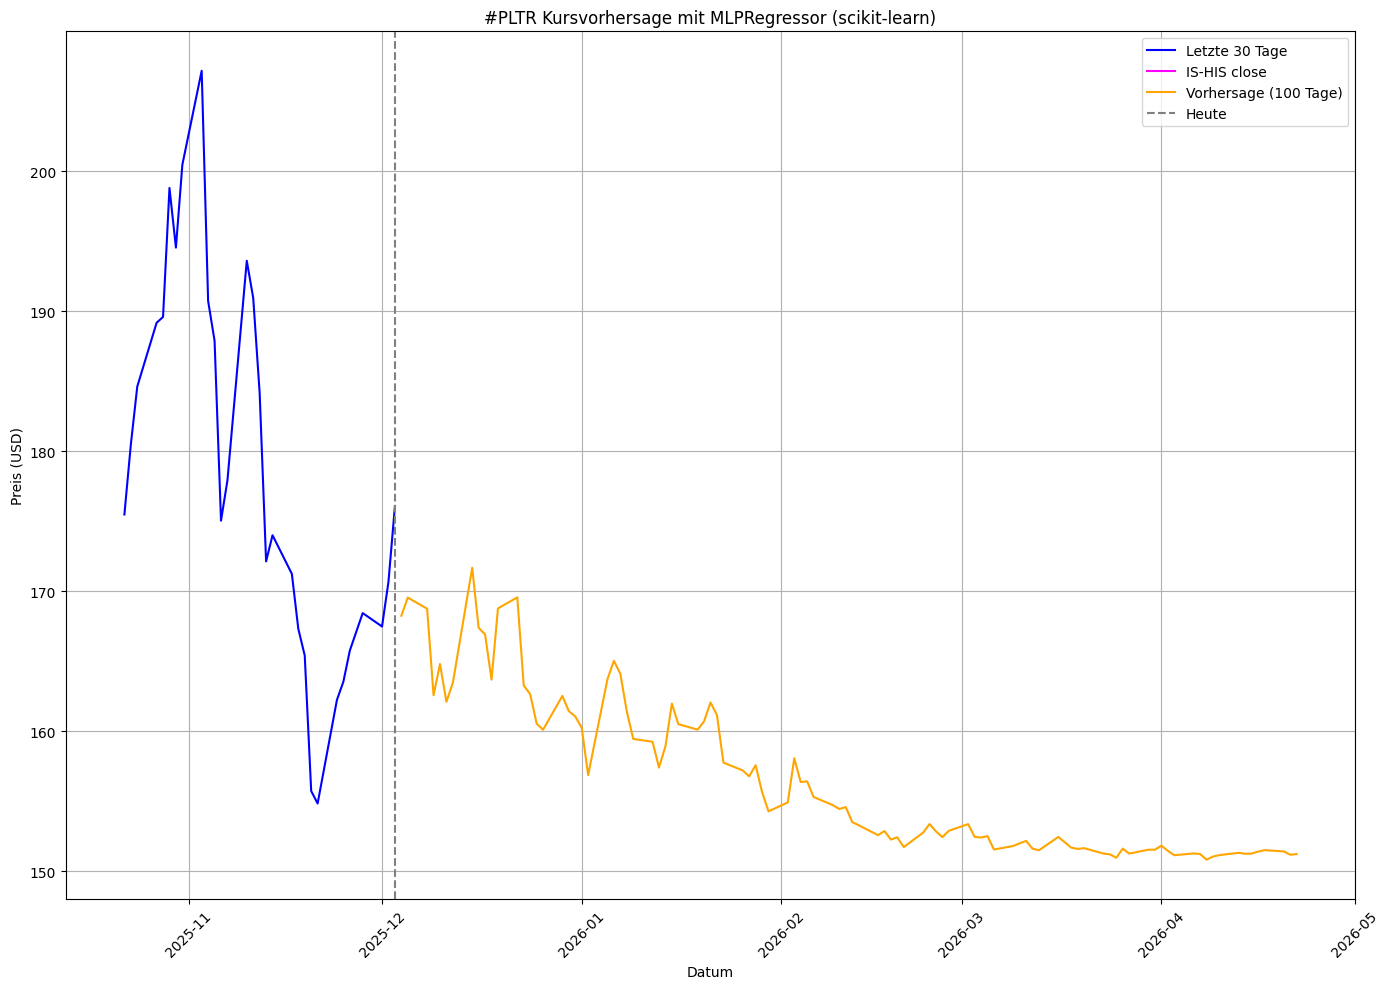

In [31]:
import matplotlib.dates as mdates

df.index = pd.to_datetime(df.index)
last_date = df.index[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=n_pred_days, freq='B')
df_fc = ['date','fc']

#plt.figure(figsize=(40, 22))
plt.figure(figsize=(14, 10))
plt.plot(df.index[-30:], df['close'].iloc[-30:], label='Letzte 30 Tage', color='blue')
#plt.plot(df.index[-30:], df['trend'].iloc[-30:], label='Down Theory', color='blue')
plt.plot(df_his['date'], df_his['close'], label='IS-HIS close', color='magenta')
plt.plot(future_dates, predicted_prices, label='Vorhersage (100 Tage)', color='orange')
plt.axvline(x=last_date, color='gray', linestyle='--', label='Heute')
plt.title(stock_symbol + ' Kursvorhersage mit MLPRegressor (scikit-learn)')
plt.xlabel('Datum')
plt.ylabel('Preis (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
print (predicted_prices)

[[168.26207865]
 [169.5573639 ]
 [168.76005073]
 [162.58063769]
 [164.81385694]
 [162.1112469 ]
 [163.47766266]
 [171.68908602]
 [167.3999645 ]
 [166.92807266]
 [163.69591753]
 [168.78246894]
 [169.57307222]
 [163.27923249]
 [162.66149826]
 [160.56243585]
 [160.11717225]
 [162.53568582]
 [161.44816489]
 [161.06534441]
 [160.26958723]
 [156.87871704]
 [163.72819795]
 [165.04031987]
 [164.11427805]
 [161.42979384]
 [159.46119554]
 [159.26004231]
 [157.4153021 ]
 [158.93606699]
 [161.98674375]
 [160.51700521]
 [160.12656493]
 [160.72080747]
 [162.06648126]
 [161.15973983]
 [157.76988549]
 [157.21082407]
 [156.78907368]
 [157.58295431]
 [155.6753577 ]
 [154.29207564]
 [154.93015031]
 [158.08160414]
 [156.38328341]
 [156.42995294]
 [155.3190459 ]
 [154.73065274]
 [154.45557743]
 [154.59372549]
 [153.52503078]
 [153.30043415]
 [152.58953363]
 [152.8826611 ]
 [152.27520334]
 [152.43545733]
 [151.73910261]
 [152.76611385]
 [153.3833966 ]
 [152.85825405]
 [152.45018359]
 [152.90315816]
 [153.37

In [33]:

#df1  = pd.DataFrame (future_dates)
df2  = pd.DataFrame (predicted_prices)

dates = future_dates
values = predicted_prices

df1 = pd.DataFrame({'date': future_dates})

print (df1)

df1['NN'] = predicted_prices

print (df1)

         date
0  2025-12-04
1  2025-12-05
2  2025-12-08
3  2025-12-09
4  2025-12-10
..        ...
95 2026-04-16
96 2026-04-17
97 2026-04-20
98 2026-04-21
99 2026-04-22

[100 rows x 1 columns]
         date          NN
0  2025-12-04  168.262079
1  2025-12-05  169.557364
2  2025-12-08  168.760051
3  2025-12-09  162.580638
4  2025-12-10  164.813857
..        ...         ...
95 2026-04-16  151.414133
96 2026-04-17  151.516422
97 2026-04-20  151.429825
98 2026-04-21  151.192938
99 2026-04-22  151.236596

[100 rows x 2 columns]


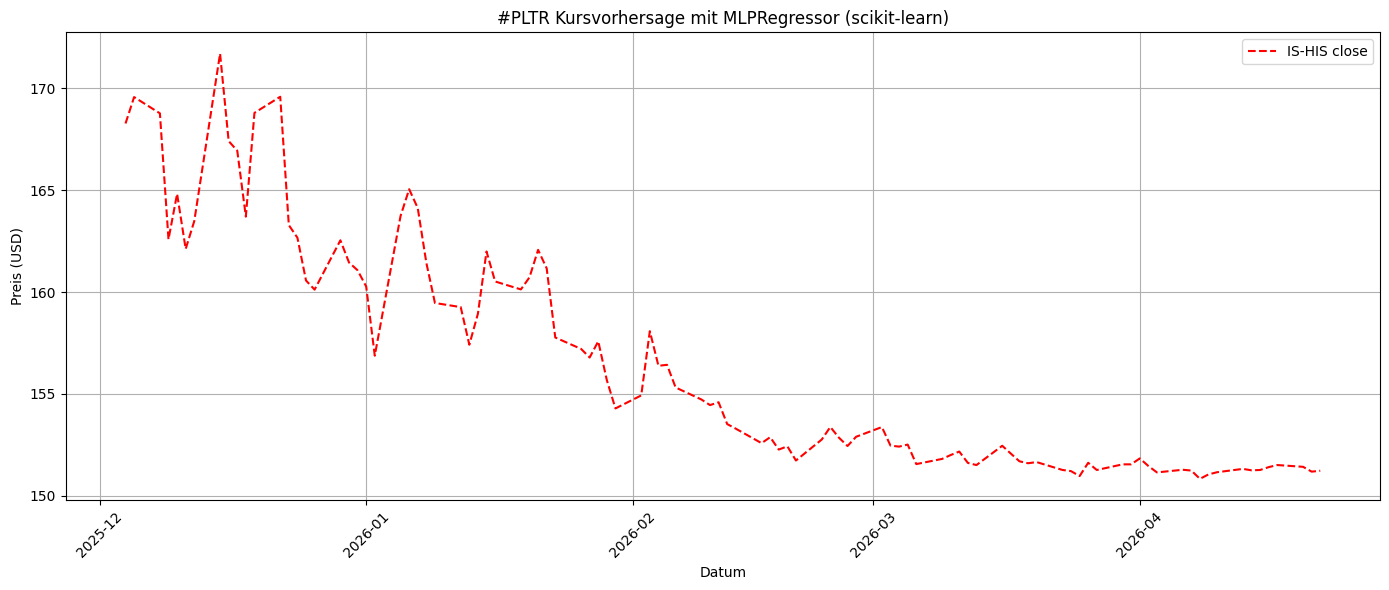

In [34]:
df1["date"] = pd.to_datetime(df1["date"]) 
#df1 = df1.set_index('date')

plt.figure(figsize=(14, 6))
#plt.plot(df.index[-30:], df['close'].iloc[-30:], label='Letzte 30 Tage', color='blue')
plt.plot( df1['date'], df1['NN'], label='IS-HIS close', color='red',  linestyle='--' )

plt.title(stock_symbol + ' Kursvorhersage mit MLPRegressor (scikit-learn)')
plt.xlabel('Datum')
plt.ylabel('Preis (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
#df1 = df1.set_index('date')
#df['NN'] = df1['NN'] 
print (df1)

         date          NN
0  2025-12-04  168.262079
1  2025-12-05  169.557364
2  2025-12-08  168.760051
3  2025-12-09  162.580638
4  2025-12-10  164.813857
..        ...         ...
95 2026-04-16  151.414133
96 2026-04-17  151.516422
97 2026-04-20  151.429825
98 2026-04-21  151.192938
99 2026-04-22  151.236596

[100 rows x 2 columns]


In [36]:
#df_fc =  pd.DataFrame ( df[['open', 'high', 'close','NN']] )
#print (df_fc)

df_combined = pd.concat([df, df1], ignore_index=True)


In [37]:
print (df_combined.tail(10) ) 

     Unnamed: 0 symbol  open  high  low  close  volume  adjclose ticker type  \
290         NaN    NaN   NaN   NaN  NaN    NaN     NaN       NaN    NaN  NaN   
291         NaN    NaN   NaN   NaN  NaN    NaN     NaN       NaN    NaN  NaN   
292         NaN    NaN   NaN   NaN  NaN    NaN     NaN       NaN    NaN  NaN   
293         NaN    NaN   NaN   NaN  NaN    NaN     NaN       NaN    NaN  NaN   
294         NaN    NaN   NaN   NaN  NaN    NaN     NaN       NaN    NaN  NaN   
295         NaN    NaN   NaN   NaN  NaN    NaN     NaN       NaN    NaN  NaN   
296         NaN    NaN   NaN   NaN  NaN    NaN     NaN       NaN    NaN  NaN   
297         NaN    NaN   NaN   NaN  NaN    NaN     NaN       NaN    NaN  NaN   
298         NaN    NaN   NaN   NaN  NaN    NaN     NaN       NaN    NaN  NaN   
299         NaN    NaN   NaN   NaN  NaN    NaN     NaN       NaN    NaN  NaN   

     ...  MA_50  MA_200  RSI_14 Sentiment  MACD  Signal_Line  Returns  \
290  ...    NaN     NaN     NaN       NaN   Na